## Lung Segmentation using UNets

In [1]:
%load_ext autoreload
%autoreload

In [2]:
from deeply.model.unet import (
    UNet,
    Trainer
)
from deeply.plots import segplot
from deeply.datasets.util import split as split_dataset

import deeply.datasets as dd

#### Prepare Dataset

In [3]:
names    = ("montgomery",)
datasets = { }

for name in names:
    datasets[name] = split_dataset(dd.load(name, shuffle_files = True)["data"])

In [4]:
train, val, test = datasets["montgomery"]

#### Show Samples

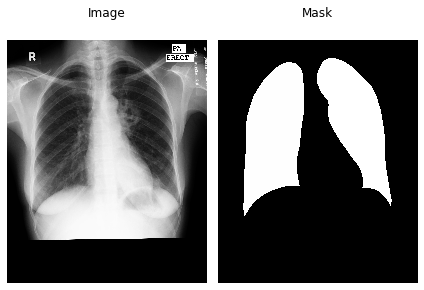

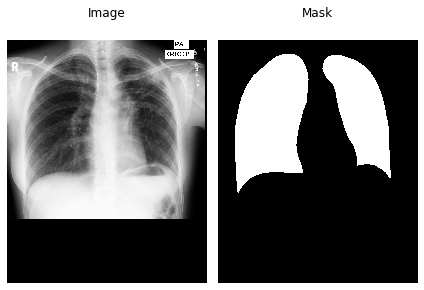

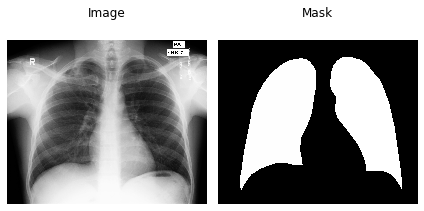

In [5]:
n_samples = 3

for data in train.take(n_samples):
    segplot(data["image"], data["mask"])

In [6]:
width, height = (256, 256)

#### Build Model

In [7]:
unet = UNet(x = width, y = height, n_classes = 1, final_activation = "sigmoid")

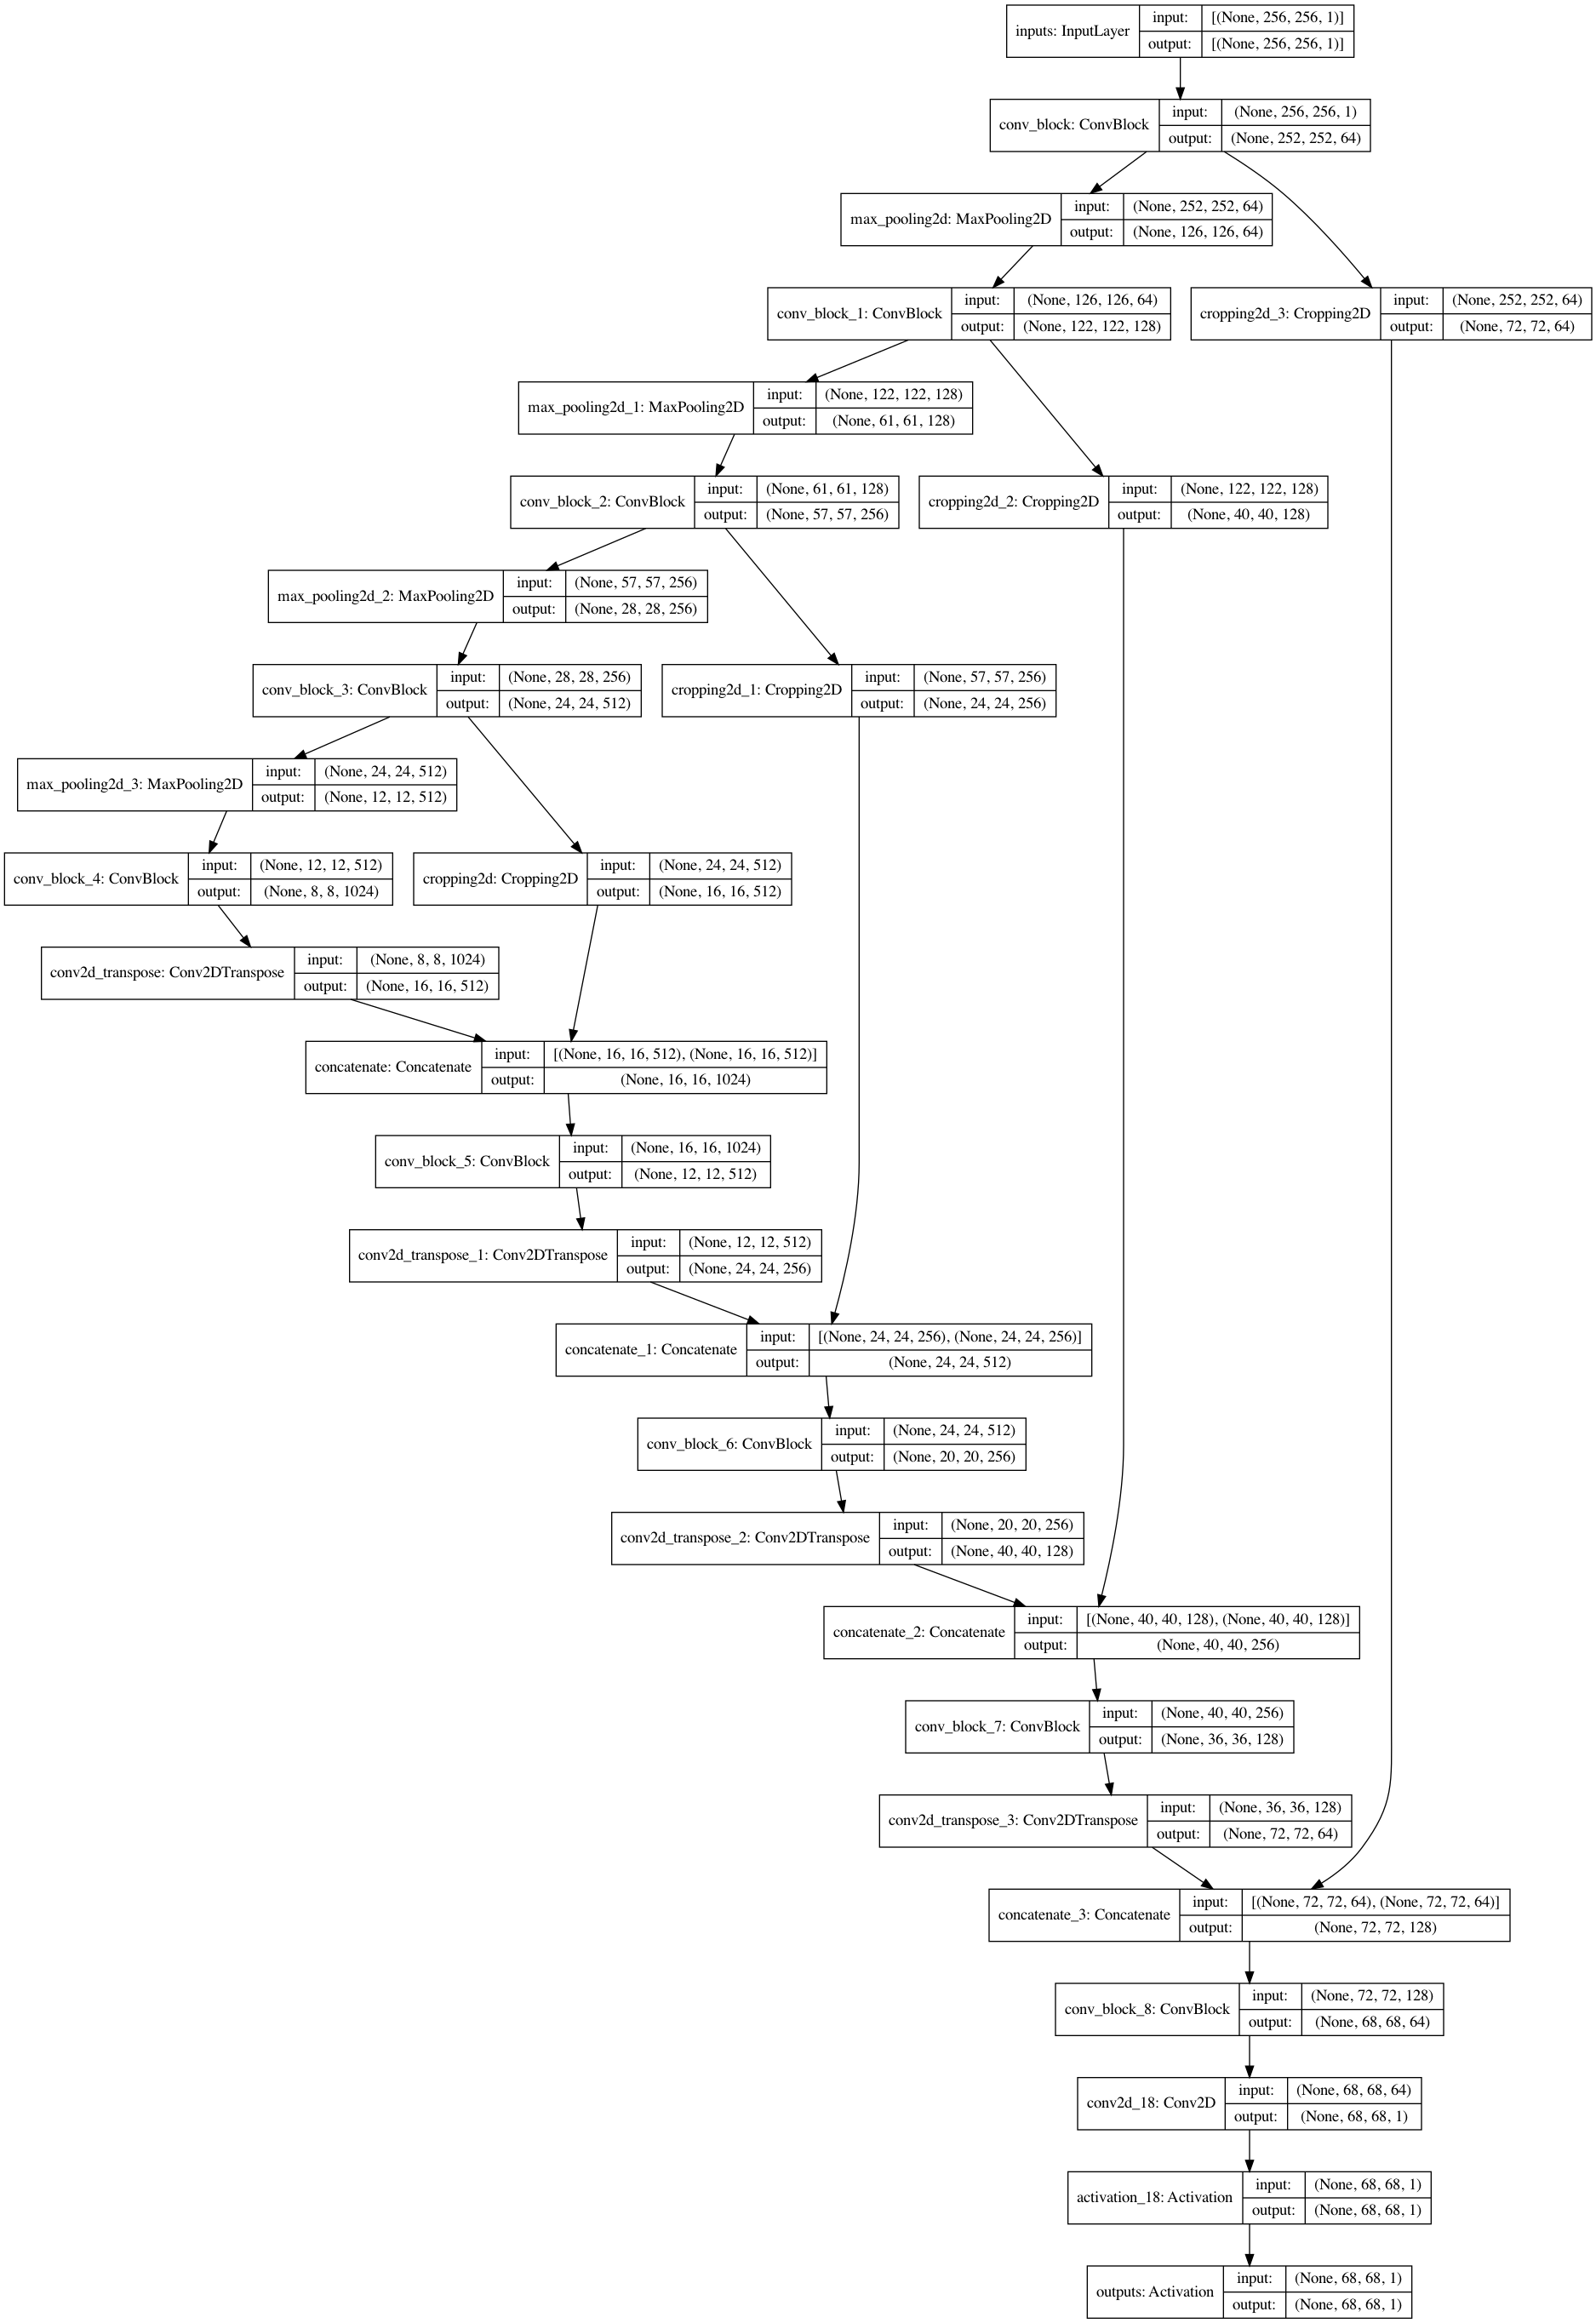

In [8]:
unet.plot()

In [9]:
from tensorflow.keras.optimizers import Adam

from deeply.losses import dice_loss

In [10]:
unet.compile(optimizer = Adam(learning_rate = 1e-5), loss = dice_loss, metrics = ["binary_accuracy"])

In [11]:
batch_size = 1
epochs = 50

#### Preprocess Data

In [12]:
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa

from deeply.util.array import squash

In [13]:
augmentor = iaa.Sequential([
    iaa.Resize({ "width": width, "height": height })
])

grayscale = tf.image.rgb_to_grayscale
from_, to = (0, 1, 2), (1, 0, 2)

def augment(image):
    image     = image.numpy()
    
    image     = np.moveaxis(image, from_, to)
    augmented = augmentor(images = [image])
    augmented = squash(augmented)
    
    augmented = np.moveaxis(augmented, to, from_)
    
    return augmented
    
def mapper(ds):
    image, mask = ds["image"], ds["mask"]
    image, mask = grayscale(image), grayscale(mask)
    
    feature = tf.py_function(augment, [image], image.dtype)
    mask    = tf.py_function(augment, [mask],  mask.dtype)
    
    return feature, mask

In [ ]:
trainer = Trainer()
history = trainer.fit(unet, train, val = val, batch_size = batch_size, epochs = epochs, mapper = mapper)

Epoch 1/50
46/83 [===============>..............] - ETA: 1:00 - loss: -0.0676 - binary_accuracy: 0.7098

In [ ]:
expected = test.map(mapper)
predict  = unet.predict(expected.batch(batch_size))

In [ ]:
for i, (image, mask) in enumerate(expected.take(n_samples)):
    segplot(image, mask, predict[i])